# UK postcode and census data

This notebook shows how to download and associate UK postcode data for geospatial work.

This is needed because:
1. The ONS has not published population data at postcode level, only at a geographic area level.
https://www.ons.gov.uk/aboutus/transparencyandgovernance/freedomofinformationfoi/ukpopulationbypostcode
2. Poscodes are routes rather than areas. So, given a postcode, we have to find the geographical region it is in.

In [ ]:
%pip install --user --quiet duckdb

## Download UK postcode location

This website contains the location of UK postcodes.  These are center locations, not polygons.

https://www.freemaptools.com/download-uk-postcode-lat-lng.htm

In [1]:
%%bash
mkdir -p indata
cd indata
if [ ! -f ukpostcodes.zip ]; then
    wget https://data.freemaptools.com/download/full-uk-postcodes/ukpostcodes.zip
    unzip ukpostcodes.zip 
fi

In [2]:
POSTCODES_CSV="indata/ukpostcodes.csv"
!head {POSTCODES_CSV}

id,postcode,latitude,longitude
1,AB10 1XG,57.144156,-2.114864
2,AB10 6RN,57.137871,-2.121487
3,AB10 7JB,57.124274,-2.127206
4,AB11 5QN,57.142701,-2.093295
5,AB11 6UL,57.137468,-2.112455
6,AB11 8RQ,57.135968,-2.072115
7,AB12 3FJ,57.097987,-2.077447
8,AB12 4NA,57.064273,-2.130018
9,AB12 5GL,57.081938,-2.246567


In [3]:
import pandas as pd
pd.read_csv(POSTCODES_CSV)

,id,postcode,latitude,longitude
0,1,AB10 1XG,57.144156,-2.114864
1,2,AB10 6RN,57.137871,-2.121487
2,3,AB10 7JB,57.124274,-2.127206
3,4,AB11 5QN,57.142701,-2.093295
4,5,AB11 6UL,57.137468,-2.112455
...,...,...,...,...
1792778,2707981,YO8 1FF,53.784954,-1.067704
1792779,2707982,YO8 9UR,53.763246,-1.134735
1792780,2707983,YO8 9UX,53.763293,-1.135007
1792781,2707984,YO8 9UY,53.763293,-1.135007


## Download UK Census data for population

This website contains UK census data from 2021:
    https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationandhouseholdestimatesenglandandwalescensus2021

In [4]:
%%bash
mkdir -p indata
cd indata
if [ ! -f census2021.xlsx ]; then
    wget -O census2021.xlsx https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationandhouseholdestimatesenglandandwalescensus2021/census2021/census2021firstresultsenglandwales1.xlsx
fi    

In [5]:
POPULATION_XLS="indata/census2021.xlsx"
!ls -l {POPULATION_XLS}

-rw-r--r-- 1 jupyter jupyter 207178 Jun  8 19:30 indata/census2021.xlsx


In [6]:
import duckdb
conn = duckdb.connect()

ukpop = conn.execute(f"""
install spatial;
load spatial;

SELECT 
  * 
FROM
st_read('{POPULATION_XLS}', layer='P01')
""").df()

In [7]:
ukpop.drop(range(0,6), axis=0)

,Field1,Field2,Field3,Field4,Field5
6,Area code [note 2],Area name,All persons,Females,Males
7,K04000001,England and Wales,59597300,30420100,29177200
8,E92000001,England,56489800,28833500,27656300
9,E12000001,North East,2647100,1353800,1293300
10,E06000047,County Durham,522100,266800,255300
...,...,...,...,...,...
377,W06000018,Caerphilly,175900,90000,86000
378,W06000019,Blaenau Gwent,66900,34100,32800
379,W06000020,Torfaen,92300,47400,44900
380,W06000021,Monmouthshire,93000,47400,45600


In [8]:
ukpop = ukpop.drop(range(0,7), axis=0).rename(columns={
    'Field1': 'area_code', 
    'Field2': 'area_name', 
    'Field3': 'all_persons', 
    'Field4': 'females', 
    'Field5': 'males'
})
ukpop

,area_code,area_name,all_persons,females,males
7,K04000001,England and Wales,59597300,30420100,29177200
8,E92000001,England,56489800,28833500,27656300
9,E12000001,North East,2647100,1353800,1293300
10,E06000047,County Durham,522100,266800,255300
11,E06000005,Darlington,107800,55100,52700
...,...,...,...,...,...
377,W06000018,Caerphilly,175900,90000,86000
378,W06000019,Blaenau Gwent,66900,34100,32800
379,W06000020,Torfaen,92300,47400,44900
380,W06000021,Monmouthshire,93000,47400,45600


In [9]:
popdensity = conn.execute(f"""
SELECT 
  * 
FROM
st_read('{POPULATION_XLS}', layer='P04')
""").df()

In [10]:
popdensity.drop(range(0,6), axis=0)

,Field1,Field2,Field3
6,Area code [note 2],Area name,Population density (number of usual residents ...
7,K04000001,England and Wales,395
8,E92000001,England,434
9,E12000001,North East,308
10,E06000047,County Durham,235
...,...,...,...
377,W06000018,Caerphilly,634
378,W06000019,Blaenau Gwent,615
379,W06000020,Torfaen,734
380,W06000021,Monmouthshire,110


In [11]:
popdensity = popdensity.drop(range(0,7), axis=0).rename(columns={
    'Field1': 'area_code', 
    'Field2': 'area_name', 
    'Field3': 'persons_per_sqkm', 
})
popdensity

,area_code,area_name,persons_per_sqkm
7,K04000001,England and Wales,395
8,E92000001,England,434
9,E12000001,North East,308
10,E06000047,County Durham,235
11,E06000005,Darlington,546
...,...,...,...
377,W06000018,Caerphilly,634
378,W06000019,Blaenau Gwent,615
379,W06000020,Torfaen,734
380,W06000021,Monmouthshire,110


In [12]:
# join the two
ukpop['persons_per_sqkm'] = popdensity['persons_per_sqkm']
ukpop

,area_code,area_name,all_persons,females,males,persons_per_sqkm
7,K04000001,England and Wales,59597300,30420100,29177200,395
8,E92000001,England,56489800,28833500,27656300,434
9,E12000001,North East,2647100,1353800,1293300,308
10,E06000047,County Durham,522100,266800,255300,235
11,E06000005,Darlington,107800,55100,52700,546
...,...,...,...,...,...,...
377,W06000018,Caerphilly,175900,90000,86000,634
378,W06000019,Blaenau Gwent,66900,34100,32800,615
379,W06000020,Torfaen,92300,47400,44900,734
380,W06000021,Monmouthshire,93000,47400,45600,110


## Write out merged population data

In [13]:
!mkdir -p temp

In [14]:
ukpop.to_csv("temp/ukpop.csv", index=False)

In [15]:
!head -3 temp/ukpop.csv

area_code,area_name,all_persons,females,males,persons_per_sqkm
K04000001,England and Wales,59597300,30420100,29177200,395
E92000001,England,56489800,28833500,27656300,434


## Download ONS data to tie postcodes to area codes

To tie postcodes to areacodes, use the data from here:

https://geoportal.statistics.gov.uk/datasets/ons-postcode-directory-february-2023-version-2/about

In [16]:
%%bash
mkdir -p indata
cd indata
if [ ! -f onspd.zip ]; then
   wget -O onspd.zip https://www.arcgis.com/sharing/rest/content/items/a2f8c9c5778a452bbf640d98c166657c/data
   unzip onspd.zip
fi

In [17]:
ONSPD_CSV="indata/Data/ONSPD_FEB_2023_UK.csv"
!head -3 {ONSPD_CSV}

pcd,pcd2,pcds,dointr,doterm,oscty,ced,oslaua,osward,parish,usertype,oseast1m,osnrth1m,osgrdind,oshlthau,nhser,ctry,rgn,streg,pcon,eer,teclec,ttwa,pct,itl,statsward,oa01,casward,park,lsoa01,msoa01,ur01ind,oac01,oa11,lsoa11,msoa11,wz11,sicbl,bua11,buasd11,ru11ind,oac11,lat,long,lep1,lep2,pfa,imd,calncv,icb,oa21,lsoa21,msoa21
"AB1 0AA","AB1  0AA","AB1 0AA","198001","199606","S99999999","S99999999","S12000033","S13002843","S99999999","0","385386","0801193","1","S08000020","S99999999","S92000003","S99999999","0","S14000002","S15000001","S09000001","S22000047","S03000012","S30000026","99ZZ00","S00001364","01C30","S99999999","S01000011","S02000007","6","3C2","S00090303","S01006514","S02001237","S34002990","S03000012","S99999999","S99999999","3","1C3",57.101474,-2.242851,"S99999999","S99999999","S23000009",6715,"S99999999","S99999999","","",""
"AB1 0AB","AB1  0AB","AB1 0AB","198001","199606","S99999999","S99999999","S12000033","S13002843","S99999999","0","385177","0801314","1","S08000020","S99

In [18]:
onspd = pd.read_csv(ONSPD_CSV)

/var/tmp/ipykernel_2451808/2676237005.py:1: DtypeWarning: Columns (18,31,40,45,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  onspd = pd.read_csv(ONSPD_CSV)


In [19]:
onspd

,pcd,pcd2,pcds,dointr,doterm,oscty,ced,oslaua,osward,parish,...,long,lep1,lep2,pfa,imd,calncv,icb,oa21,lsoa21,msoa21
0,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606.0,S99999999,S99999999,S12000033,S13002843,S99999999,...,-2.242851,S99999999,S99999999,S23000009,6715,S99999999,S99999999,NaN,NaN,NaN
1,AB1 0AB,AB1 0AB,AB1 0AB,198001,199606.0,S99999999,S99999999,S12000033,S13002843,S99999999,...,-2.246308,S99999999,S99999999,S23000009,6715,S99999999,S99999999,NaN,NaN,NaN
2,AB1 0AD,AB1 0AD,AB1 0AD,198001,199606.0,S99999999,S99999999,S12000033,S13002843,S99999999,...,-2.248342,S99999999,S99999999,S23000009,6715,S99999999,S99999999,NaN,NaN,NaN
3,AB1 0AE,AB1 0AE,AB1 0AE,199402,199606.0,S99999999,S99999999,S12000034,S13002864,S99999999,...,-2.255708,S99999999,S99999999,S23000009,5069,S99999999,S99999999,NaN,NaN,NaN
4,AB1 0AF,AB1 0AF,AB1 0AF,199012,199207.0,S99999999,S99999999,S12000033,S13002843,S99999999,...,-2.258102,S99999999,S99999999,S23000009,6253,S99999999,S99999999,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687269,ZE3 9JW,ZE3 9JW,ZE3 9JW,198001,NaN,S99999999,S99999999,S12000027,S13003155,S99999999,...,-1.305697,S99999999,S99999999,S23000009,4141,S99999999,S99999999,NaN,NaN,NaN
2687270,ZE3 9JX,ZE3 9JX,ZE3 9JX,198001,NaN,S99999999,S99999999,S12000027,S13003155,S99999999,...,-1.307502,S99999999,S99999999,S23000009,4141,S99999999,S99999999,NaN,NaN,NaN
2687271,ZE3 9JY,ZE3 9JY,ZE3 9JY,198001,NaN,S99999999,S99999999,S12000027,S13003155,S99999999,...,-1.313847,S99999999,S99999999,S23000009,4141,S99999999,S99999999,NaN,NaN,NaN
2687272,ZE3 9JZ,ZE3 9JZ,ZE3 9JZ,198001,NaN,S99999999,S99999999,S12000027,S13003155,S99999999,...,-1.310899,S99999999,S99999999,S23000009,4141,S99999999,S99999999,NaN,NaN,NaN


In [20]:
onspd = onspd[['pcd', 'oslaua', 'osward', 'parish']]

In [21]:
onspd

,pcd,oslaua,osward,parish
0,AB1 0AA,S12000033,S13002843,S99999999
1,AB1 0AB,S12000033,S13002843,S99999999
2,AB1 0AD,S12000033,S13002843,S99999999
3,AB1 0AE,S12000034,S13002864,S99999999
4,AB1 0AF,S12000033,S13002843,S99999999
...,...,...,...,...
2687269,ZE3 9JW,S12000027,S13003155,S99999999
2687270,ZE3 9JX,S12000027,S13003155,S99999999
2687271,ZE3 9JY,S12000027,S13003155,S99999999
2687272,ZE3 9JZ,S12000027,S13003155,S99999999


In [22]:
onspd.to_csv("temp/onspd.csv", index=False)

In [23]:
!head -3 temp/onspd.csv

pcd,oslaua,osward,parish
AB1 0AA,S12000033,S13002843,S99999999
AB1 0AB,S12000033,S13002843,S99999999


## Now tie postcode to area code, and get the population statistics

Use DuckDB for this

In [24]:
ukpop = conn.execute(f"""

/* pcd,oslaua,osward,parish */
WITH onspd AS (
    SELECT 
      * 
    FROM
    read_csv_auto('temp/onspd.csv', header=True)
),

/* area_code,area_name,all_persons,females,males,persons_per_sqkm */
ukpop AS (
    SELECT 
      * 
    FROM
    read_csv_auto('temp/ukpop.csv', header=True)
),

/* id,postcode,latitude,longitude */
postcodes AS (
    SELECT 
      * 
    FROM
    read_csv_auto('indata/ukpostcodes.csv', header=True)
),

/* postcode, area_code */
postcode_to_areacode AS (
  SELECT 
    pcd AS postcode,
    ANY_VALUE(area_code) as area_code
  FROM onspd
  JOIN ukpop 
  ON (area_code = oslaua OR area_code = osward OR area_code = parish)
  GROUP BY pcd
)

SELECT
  postcode, latitude, longitude, /* from postcodes */
  area_code, area_name, persons_per_sqkm /* from ukpop */
FROM postcode_to_areacode
JOIN postcodes USING (postcode)
JOIN ukpop USING (area_code)

""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [25]:
ukpop

,postcode,latitude,longitude,area_code,area_name,persons_per_sqkm
0,AL1 1AJ,51.744498,-0.328599,E07000240,St Albans,919
1,AL1 1AS,51.749073,-0.335471,E07000240,St Albans,919
2,AL1 1AW,51.741787,-0.322216,E07000240,St Albans,919
3,AL1 1BU,51.749723,-0.340691,E07000240,St Albans,919
4,AL1 1BX,51.749086,-0.341010,E07000240,St Albans,919
...,...,...,...,...,...,...
773881,YO8 8HP,53.724805,-1.020636,E07000169,Selby,154
773882,YO8 8LH,53.749141,-1.101536,E07000169,Selby,154
773883,YO8 9ES,53.767079,-1.093947,E07000169,Selby,154
773884,YO8 5RA,53.825263,-0.961248,E07000169,Selby,154


In [26]:
ukpop.to_csv("ukpopulation.csv", index=False)

In [27]:
%%bash
rm ukpopulation.csv.gz
gzip ukpopulation.csv
ls -l ukpopulation*

-rw-r--r-- 1 jupyter jupyter 8377236 Jun 21 18:16 ukpopulation.csv.gz


In [28]:
%%bash
zcat ukpopulation.csv.gz | head -3

postcode,latitude,longitude,area_code,area_name,persons_per_sqkm
AL1 1AJ,51.744498,-0.328599,E07000240,St Albans,919
AL1 1AS,51.749073,-0.335471,E07000240,St Albans,919


## Area coverage of postcodes

In many cases, we'd nevertheless like to have a polygon for each postcode.

Unfortunately, DuckDB doesn't have [ST_VoronoiPolygons](https://postgis.net/docs/ST_VoronoiPolygons.html), so let's use Python.

In [29]:
import pandas as pd
df = pd.read_csv("ukpopulation.csv.gz")

In [30]:
df

,postcode,latitude,longitude,area_code,area_name,persons_per_sqkm
0,AL1 1AJ,51.744498,-0.328599,E07000240,St Albans,919
1,AL1 1AS,51.749073,-0.335471,E07000240,St Albans,919
2,AL1 1AW,51.741787,-0.322216,E07000240,St Albans,919
3,AL1 1BU,51.749723,-0.340691,E07000240,St Albans,919
4,AL1 1BX,51.749086,-0.341010,E07000240,St Albans,919
...,...,...,...,...,...,...
773881,YO8 8HP,53.724805,-1.020636,E07000169,Selby,154
773882,YO8 8LH,53.749141,-1.101536,E07000169,Selby,154
773883,YO8 9ES,53.767079,-1.093947,E07000169,Selby,154
773884,YO8 5RA,53.825263,-0.961248,E07000169,Selby,154


In [31]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

points = df[['latitude', 'longitude']].to_numpy()
points[:3]

array([[51.744498, -0.328599],
       [51.749073, -0.335471],
       [51.741787, -0.322216]])

In [32]:
vor = Voronoi(points)

### Let's go through and create a polygon for each input point

The way "vor" is organized is that for each point, there is a region number into an array of regoins.
Each region is an array of indexes into an array of vertices

In [33]:
vor.point_region[:3]

array([454025, 524461, 587284])

In [34]:
vor.regions[:3]

[[57, 20, 5, 6, 56], [82, 78, 77, 79, 80, 81], [80, 12, 13, 2, 79]]

In [35]:
vor.vertices[:3]

array([[54.82203314, -3.41659355],
       [50.28318767, -5.2455375 ],
       [53.79634897, -0.22277092]])

In [36]:
def make_polygon(point_no):
    region_no = vor.point_region[point_no]
    region = vor.regions[region_no]
    if len(region) >= 3:
        # close the ring
        closed_region = region.copy()
        closed_region.append(closed_region[0])
        # create a WKT of the points
        polygon = "POLYGON ((" + ','.join([ f"{vor.vertices[v][1]} {vor.vertices[v][0]}" for v in closed_region]) + "))"
        return polygon
    else:
        return None

make_polygon(2)

'POLYGON ((-0.32491691953979235 51.7393550489536,-0.32527234008402217 51.73948967705648,-0.32515738641624575 51.73987124225542,-0.3241646650618929 51.74087626616231,-0.3215663358407994 51.742660660928614,-0.32145633473723817 51.742228570262824,-0.32491691953979235 51.7393550489536))'

In [37]:
df['geometry'] = [make_polygon(x) for x in range(len(vor.point_region))]

In [38]:
df.head()

,postcode,latitude,longitude,area_code,area_name,persons_per_sqkm,geometry
0,AL1 1AJ,51.744498,-0.328599,E07000240,St Albans,919,POLYGON ((-0.32891823368478534 51.744882841822...
1,AL1 1AS,51.749073,-0.335471,E07000240,St Albans,919,POLYGON ((-0.3359766905654176 51.7491766911407...
2,AL1 1AW,51.741787,-0.322216,E07000240,St Albans,919,POLYGON ((-0.32491691953979235 51.739355048953...
3,AL1 1BU,51.749723,-0.340691,E07000240,St Albans,919,POLYGON ((-0.34105551990171284 51.750269590626...
4,AL1 1BX,51.749086,-0.341010,E07000240,St Albans,919,POLYGON ((-0.3408694515593898 51.7490004114134...


### Plot it to make sure they look reasonable

In [39]:
import geopandas as gpd
from shapely import wkt
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.head()

,postcode,latitude,longitude,area_code,area_name,persons_per_sqkm,geometry
0,AL1 1AJ,51.744498,-0.328599,E07000240,St Albans,919,"POLYGON ((-0.32892 51.74488, -0.32938 51.74441..."
1,AL1 1AS,51.749073,-0.335471,E07000240,St Albans,919,"POLYGON ((-0.33598 51.74918, -0.33529 51.74947..."
2,AL1 1AW,51.741787,-0.322216,E07000240,St Albans,919,"POLYGON ((-0.32492 51.73936, -0.32527 51.73949..."
3,AL1 1BU,51.749723,-0.340691,E07000240,St Albans,919,"POLYGON ((-0.34106 51.75027, -0.34116 51.74961..."
4,AL1 1BX,51.749086,-0.341010,E07000240,St Albans,919,"POLYGON ((-0.34087 51.74900, -0.34074 51.74930..."


<Axes: >

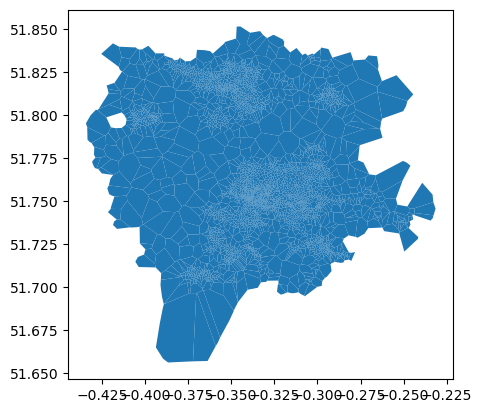

In [40]:
# plot a few postcodes
gdf[gdf['area_name'] == 'St Albans'].plot()

<Axes: >

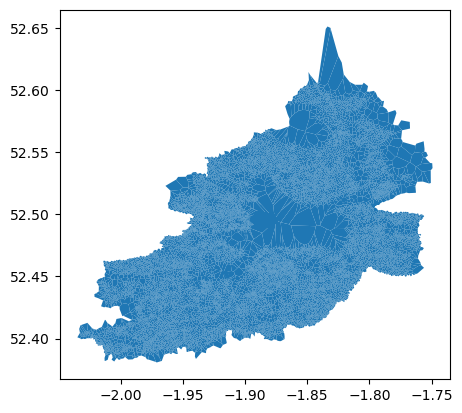

In [41]:
# plot a few postcodes
gdf[gdf['area_name'] == 'Birmingham'].plot()

## Save

In [42]:
gdf.to_csv("ukpostcodes.csv", index=False)

In [43]:
%%bash
rm ukpostcodes.csv.gz
gzip ukpostcodes.csv
ls -l *.csv*

-rw-r--r-- 1 jupyter jupyter  8377236 Jun 21 18:16 ukpopulation.csv.gz
-rw-r--r-- 1 jupyter jupyter 79145743 Jun 21 18:17 ukpostcodes.csv.gz


In [44]:
%%bash
zcat ukpostcodes.csv.gz | head -3

postcode,latitude,longitude,area_code,area_name,persons_per_sqkm,geometry
AL1 1AJ,51.744498,-0.328599,E07000240,St Albans,919,"POLYGON ((-0.3289182336847853 51.74488284182215, -0.3293825998789896 51.744405074006174, -0.329604287673916 51.74236314244929, -0.329028694301477 51.741790471797884, -0.3281347006741423 51.74474023878947, -0.3282546242225033 51.74490714065347, -0.3289182336847853 51.74488284182215))"
AL1 1AS,51.749073,-0.335471,E07000240,St Albans,919,"POLYGON ((-0.3359766905654176 51.7491766911407, -0.3352895401257449 51.74947208976144, -0.3350081251733815 51.748767953625304, -0.3352244618999447 51.74869091284858, -0.3359553303979663 51.74907577524753, -0.3359766905654176 51.7491766911407))"


Load this into BigQuery (the geometry column is a string because I didn't specify a schema) and query it ...

In [45]:
%%bigquery
SELECT 
  COUNT(*) AS num_postcodes,
  SUM(ST_AREA(SAFE.ST_GEOGFROMTEXT(geometry, make_valid=>TRUE)))/10e6 AS total_area,
  AVG(persons_per_sqkm) AS popdensity,
  area_name
 FROM uk_public_data.postcode_popgeo
 GROUP BY area_name
 ORDER BY popdensity DESC

Query is running:   0%|          |

Downloading:   0%|          |

,num_postcodes,total_area,popdensity,area_name
0,2380,13.988427,15695.0,Tower Hamlets
1,1502,141.623995,14578.0,Islington
2,1115,1.647558,13611.0,Hackney
3,3994,2.893263,11848.0,Lambeth
4,2859,1.779630,11828.0,Kensington and Chelsea
...,...,...,...,...
288,437,66.803237,48.0,Craven
289,1261,187.453340,38.0,Richmondshire
290,16,37.811426,36.0,Ryedale
291,364,174.745812,26.0,Eden


Note the need to make the polygons valid.
Let's create a new version of the table with the geometry column to simplify

In [46]:
%%bigquery
CREATE OR REPLACE TABLE uk_public_data.postcode_popgeo2
CLUSTER BY postcode
AS

SELECT 
  * EXCEPT(geometry),
  SAFE.ST_GEOGFROMTEXT(geometry, make_valid=>TRUE) AS geometry,
FROM uk_public_data.postcode_popgeo

Query is running:   0%|          |

""


In [47]:
%%bigquery
SELECT 
  COUNT(*) AS num_postcodes,
  SUM(ST_AREA(geometry))/10e6 AS total_area,
  AVG(persons_per_sqkm) AS popdensity,
  area_name
 FROM uk_public_data.postcode_popgeo2
 GROUP BY area_name
 ORDER BY popdensity DESC

Query is running:   0%|          |

Downloading:   0%|          |

,num_postcodes,total_area,popdensity,area_name
0,2380,13.988427,15695.0,Tower Hamlets
1,1502,141.623995,14578.0,Islington
2,1115,1.647558,13611.0,Hackney
3,3994,2.893263,11848.0,Lambeth
4,2859,1.779630,11828.0,Kensington and Chelsea
...,...,...,...,...
288,437,66.803237,48.0,Craven
289,1261,187.453340,38.0,Richmondshire
290,16,37.811426,36.0,Ryedale
291,364,174.745812,26.0,Eden


## Apache 2 Licensed

Copyright 2023 V Lakshmanan

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.